<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

In [22]:
import numpy as np
import copy
# import jax.numpy as np

from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [23]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        """
        q: (batch_size, n_heads, seq_len, head_size)
        k: (batch_size, n_heads, seq_len, head_size)
        v: (batch_size, n_heads, seq_len, head_size)
        """
        d_k = q.shape[-1]
        scores = torch.matmul(q, k.transpose(-2, -1)) / np.sqrt(d_k)  # (batch_size, n_heads, seq_len, seq_len)
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention_weights = torch.softmax(scores, dim=-1)  # (batch_size, n_heads, seq_len, seq_len)
        attention_weights = self.dropout(attention_weights)  # (batch_size, n_heads, seq_len, seq_len)

        output = torch.matmul(attention_weights, v)  # (batch_size, n_heads, seq_len, head_size)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0, cache=False):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_size = d_model // n_heads
        self.use_cache = cache

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.attention = ScaledDotProductAttention(dropout=dropout)
        self.cached_k = None
        self.cached_v = None

    def split_heads(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, d_model = x.shape
        return x.view(batch_size, seq_len, self.n_heads, self.head_size).transpose(1, 2)  # (batch_size, n_heads, seq_len, head_size)
    
    def combine_heads(self, x):
        """
        x: (batch_size, n_heads, seq_len, head_size)
        """
        batch_size, n_heads, seq_len, head_size = x.shape
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)  # (batch_size, seq_len, d_model)
    
    def forward(self, x, mask=None, use_cache=False, past_key_values=None):
        batch_size, seq_len, d_model = x.shape
        if past_key_values is not None:
            self.cached_k, self.cached_v = past_key_values
        q = self.W_q(x)  # (batch_size, seq_len, d_model)
        k = self.W_k(x)
        v = self.W_v(x)

        q = self.split_heads(q)  # (batch_size, n_heads, seq_len, head_size)
        k = self.split_heads(k)
        v = self.split_heads(v)
        
        # Use KV cache if enabled
        if use_cache and self.cached_k is not None and self.cached_v is not None:
            # Concatenate current k, v with cached k, v
            k = torch.cat([self.cached_k, k], dim=2)
            v = torch.cat([self.cached_v, v], dim=2)


            self.cached_k = k
            self.cached_v = v
        
        # Create causal mask if needed
        if mask is None:
            # If using cache, adjust mask to account for the full sequence length
            full_seq_len = k.size(2)
            # For cached version, we need to adjust the mask to allow attention to all past tokens
            if use_cache and self.cached_k is not None:
                # Create a mask where current tokens can attend to all previous tokens
                # Current sequence position is at seq_len
                seq_position = seq_len
                # Create a mask that allows each token to see itself and all previous tokens
                mask = torch.ones(seq_len, full_seq_len).to(x.device)
                # Make it causal by setting future positions to 0
                mask[:, seq_position:] = 0
            else:
                # Standard causal mask for the full sequence
                mask = torch.tril(torch.ones(full_seq_len, full_seq_len)).to(x.device)
            
            mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, seq_len, seq_len)

        # Use the attention module directly
        output = self.attention(q, k, v, mask)  # (batch_size, n_heads, seq_len, head_size)
        
        # Combine heads
        output = self.combine_heads(output)  # (batch_size, seq_len, d_model)
        past_key_values = (k, v)
        if use_cache:
            return self.dropout(self.out(output)) , past_key_values
        else:
            return self.dropout(self.out(output))
    
    def clear_cache(self):
        self.cached_k = None
        self.cached_v = None
    
class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1, use_cache=False):
        super().__init__()
        self.masked_mha = MultiHeadAttention(d_model, n_heads, dropout, cache=use_cache)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.GELU(),  
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout)
        )
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, use_cache=False, past_key_values=None):

        # Self-attention with residual connection and layer normalization
        residual = x
        x = self.layer_norm1(x)  # Pre-norm architecture
        if use_cache and past_key_values is not None:
            x, past_key_values = self.masked_mha(x, use_cache=use_cache, past_key_values=past_key_values)
        else:
            x = self.masked_mha(x)
            
        x = residual + x  # Residual connection
        
        # Feed forward with residual connection and layer normalization
        residual = x
        x = self.layer_norm2(x)  # Pre-norm architecture
        x = self.feed_forward(x)
        x = residual + x  # Residual connection
        if use_cache:
            return x , past_key_values
        else:
            return x
    
    def clear_cache(self):
        self.masked_mha.clear_cache()

class iGPT(nn.Module):
    def __init__(self, vocab_size, context_length, d_model, n_heads, n_layers, dropout=0.1, use_cache=False):
        super().__init__()
        self.vocab_size = vocab_size
        self.context_length = context_length
        self.d_model = d_model
        self.n_heads = n_heads  
        self.n_layers = n_layers
        self.dropout = dropout
        self.use_cache = use_cache
        
        # Token embedding
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        
        # Positional embedding (learned, as per iGPT specs)
        self.position_embedding = nn.Embedding(context_length, d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Stack of decoder layers
        self.decoder_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, dropout, use_cache=use_cache) 
            for _ in range(n_layers)
        ])
        
        # Final layer norm
        self.layer_norm = nn.LayerNorm(d_model)
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x, past_key_values=None, use_cache=False):
        # x shape: (batch_size, seq_len)
        batch_size, seq_len = x.shape
        device = x.device
        
        # Create position indices
        positions = torch.arange(0, seq_len, dtype=torch.long, device=device).unsqueeze(0).expand(batch_size, -1)
        
        # Get embeddings
        token_emb = self.token_embedding(x)  # (batch_size, seq_len, d_model)
        pos_emb = self.position_embedding(positions)  # (batch_size, seq_len, d_model)
        
        # Combine embeddings
        x = token_emb + pos_emb  # (batch_size, seq_len, d_model)
        x = self.dropout(x)
        
        # Apply decoder layers
        past_key_values = None
        for layer in self.decoder_layers:
            if use_cache:
                x, past_key_values = layer(x, use_cache=use_cache, past_key_values=past_key_values)
            else:
                x = layer(x)
        
        # Apply final layer norm
        x = self.layer_norm(x)  # (batch_size, seq_len, d_model)
        
        # Project to vocabulary
        logits = self.output_projection(x)  # (batch_size, seq_len, vocab_size)
        if use_cache:
            return logits, past_key_values
        else:
            return logits
    
    def clear_cache(self):
        for layer in self.decoder_layers:
            layer.clear_cache()

In [24]:
import math


def evaluate_model(model, data_loader, sequence_length, vocab_size, device):
    """
    Evaluates model performance on a dataset.
    
    Args:
        model: The iGPT model
        data_loader: DataLoader containing tokenized sequences (already includes BOS token)
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to run evaluation on
        
    Returns:
        Average loss (negative log-likelihood) per dimension
    """
    model.eval()
    total_loss = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in data_loader:
            data = data.to(device)  # Shape: (batch_size, sequence_length)
            batch_size = data.size(0)
            
            # Data already includes BOS token at the beginning
            # Create input sequence (all tokens except the last one)
            input_seq = data[:, :-1]  # Shape: (batch_size, sequence_length-1)
            
            # Create targets (all tokens except the first BOS token)
            targets = data[:, 1:]  # Shape: (batch_size, sequence_length-1)
            
            # Forward pass
            logits = model(input_seq)  # Shape: (batch_size, sequence_length-1, vocab_size)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1), reduction='sum')
            
            total_loss += loss.item()
            total_samples += batch_size * (sequence_length - 1)
    
    return total_loss / total_samples



def train_igpt(model, train_loader, test_loader, sequence_length, vocab_size, 
               device, num_epochs, learning_rate, dropout = 0.1):
    """
    Trains the iGPT model.
    
    Args:
        model: The iGPT model to train
        train_loader: DataLoader for training data (already includes BOS token)
        test_loader: DataLoader for test data (already includes BOS token)
        sequence_length: Length of token sequences including <bos>
        vocab_size: Size of vocabulary
        device: Device to train on
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate
        
    Returns:
        train_losses: Array of training losses per minibatch
        test_losses: Array of test losses per epoch
    """
    # Initialize optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler with warmup and cosine decay
    warmup_steps = 1000
    total_steps = len(train_loader) * num_epochs
    
    def lr_lambda(step):
        if step < warmup_steps:
            return step / warmup_steps
        else:
            decay_ratio = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
    
    # Initialize arrays to store losses
    train_losses = []
    test_losses = [evaluate_model(model, test_loader, sequence_length, vocab_size, device)]
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        
        for (batch_idx,data) in enumerate(train_loader):
            data = data.to(device)  # Shape: (batch_size, sequence_length)
            batch_size = data.size(0)
            
            # Data already includes BOS token at the beginning
            # Create input sequence (all tokens except the last one)
            input_seq = data[:, :-1]  # Shape: (batch_size, sequence_length-1)
            
            # Create targets (all tokens except the first BOS token)
            targets = data[:, 1:]  # Shape: (batch_size, sequence_length-1)
            
            # Forward pass
            logits = model(input_seq)  # Shape: (batch_size, sequence_length-1, vocab_size)
            
            # Compute loss
            loss = F.cross_entropy(logits.reshape(-1, vocab_size), targets.reshape(-1))
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            # Record loss
            train_losses.append(loss.item())
            epoch_losses.append(loss.item())
            
            if batch_idx % 50 == 0:
                print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
        
        # Evaluate on test set after each epoch
        test_loss = evaluate_model(model, test_loader, sequence_length, vocab_size, device)
        test_losses.append(test_loss)
        print(f"Epoch {epoch+1}/{num_epochs} completed. Test Loss: {test_loss:.4f}")
    
    return np.array(train_losses), np.array(test_losses)


# Question 4: Causal Transformer: Tokenized Images

In [25]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#    
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#    
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
# 

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

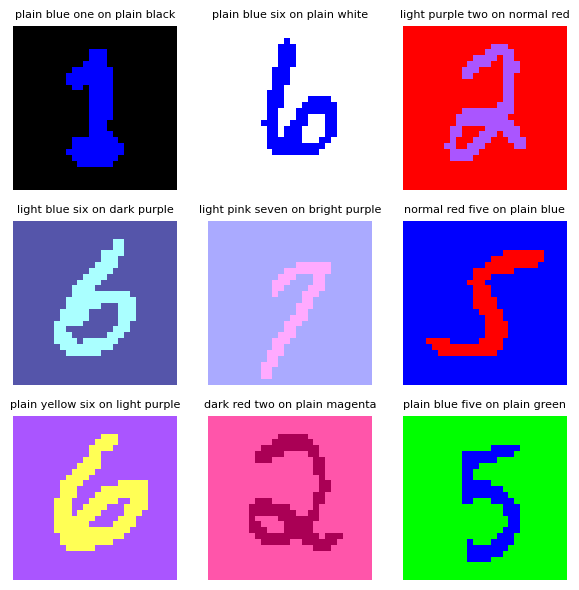

In [26]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [27]:
class Tokenizer:
    def __init__(self, texts, offset):
        self.texts = texts
        self.offset = offset
        self.all_words = set()
        for text in texts:
            self.all_words.update(text.split())
        
        # Convert set to list for consistent ordering
        self.all_words = list(self.all_words)
        self.vocab_size = len(self.all_words)

        # Add special tokens after calculating vocab_size
        # Reserve token 0 for BOS token
        self.bos_token = 0
        self.end_of_text_token = self.vocab_size + self.offset
        self.end_of_image_token = self.vocab_size + 1 + self.offset
        self.all_words.extend(['<end_of_text>', '<end_of_image>'])
        
        # Create mappings with offset applied (starting from 1 to reserve 0 for BOS)
        self.word_to_id = {word: i + 1 + self.offset for i, word in enumerate(self.all_words)}
        self.id_to_word = {i + 1 + self.offset: word for i, word in enumerate(self.all_words)}
        # Add BOS token to mappings
        self.id_to_word[self.bos_token] = '<bos>'

        
    def text_encode(self, text):
        tokens = [self.word_to_id[word] for word in text.split()]
        return torch.tensor(tokens)
        
    def text_decode(self, tokens):
        return ' '.join([self.id_to_word[token] for token in tokens if token != self.end_of_text_token and token != self.bos_token])
    
def create_dataset(images, texts, vqvae, text_tokenizer, batch_size):
    # create a dataset of images and texts
    dataset = []
    bos_token = text_tokenizer.bos_token
    end_of_image_token = text_tokenizer.end_of_image_token
    end_of_text_token = text_tokenizer.end_of_text_token
 
    print(f"Creating dataset from {len(images)} samples...")
    
    # Pre-tokenize all text data at once for efficiency
    print("Pre-tokenizing all text data...")
    all_text_tokens = [text_tokenizer.text_encode(text) for text in texts]
    
    # Batch process images for VQVAE quantization
    print("Batch processing images...")
    batch_size_process = 128
    all_image_tokens = []

    for i in range(0, len(images), batch_size_process):
        batch_end = min(i + batch_size_process, len(images))
        batch_images = images[i:batch_end]
        
        # Process batch of images
        batch_image_tokens = vqvae.quantize(batch_images)
        
        # Flatten each image's tokens and store
        for j in range(batch_image_tokens.shape[0]):
            image_tokens_flat = batch_image_tokens[j].flatten()
            all_image_tokens.append(image_tokens_flat)
        
        if i % (batch_size_process * 1000) == 0:
            print(f"Processed {min(i + batch_size_process, len(images))}/{len(images)} images ({min(i + batch_size_process, len(images))/len(images)*1000:.1f}%)")
    
    # Create special token tensors once
    bos_tensor = torch.tensor([bos_token])
    end_of_image_tensor = torch.tensor([end_of_image_token])
    end_of_text_tensor = torch.tensor([end_of_text_token])
    
    print("Assembling dataset...")
    for idx in range(len(texts)):
        text_tokens = all_text_tokens[idx]
        image_tokens_flat = all_image_tokens[idx]
        
        if idx % 2 == 0:
            # text followed by image
            complete_tokens = torch.cat((bos_tensor, end_of_image_tensor, text_tokens, end_of_text_tensor, image_tokens_flat))
            dataset.append(complete_tokens)
        else:
            # image followed by text
            complete_tokens = torch.cat((bos_tensor, end_of_text_tensor, image_tokens_flat, end_of_image_tensor, text_tokens))
            dataset.append(complete_tokens)
    
    print(f"Dataset creation complete! Total samples: {len(dataset)}")
    print(f"Creating DataLoader with batch_size={batch_size}")
    
    # create dataloader
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [28]:
import torch

class ConditionalGenerator:
    """Handles conditional and unconditional sample generation for multimodal models."""
    
    def __init__(self, model, text_tokenizer, vqvae, device, temperature=0.7):
        self.model = model
        self.text_tokenizer = text_tokenizer
        self.vqvae = vqvae
        self.device = device
        self.temperature = temperature
        
    def _create_token_mask(self, logits_shape, allowed_tokens):
        """Create a mask for allowed tokens."""
        mask = torch.zeros_like(logits_shape, device=self.device)
        mask = torch.where(allowed_tokens, 1, 0)
        return mask
    
    def _sample_next_token(self, logits, mask):
        """Sample next token with temperature and masking."""
        masked_logits = logits * mask + (1 - mask) * (-1e9)
        probs = torch.softmax(masked_logits, dim=-1)
        
        # Apply temperature
        probs = probs ** (1 / self.temperature)
        probs = probs / probs.sum(dim=-1, keepdim=True)
        
        return torch.multinomial(probs, 1)
    
    def _get_text_token_mask(self, logits_shape):
        """Get mask for valid text tokens."""
        mask = torch.zeros(logits_shape, device=self.device)
        for word, token_id in self.text_tokenizer.word_to_id.items():
            if word not in ['<end_of_text>', '<end_of_image>']:
                mask[token_id] = 1
        return mask
    
    def _get_image_token_mask(self, logits_shape):
        """Get mask for valid image tokens."""
        mask = torch.zeros(logits_shape, device=self.device)
        mask[:self.vqvae.n_embeddings] = 1
        return mask
    
    def _generate_tokens(self, input_seq, num_tokens, token_type):
        """Generate a sequence of tokens of specified type."""
        for _ in range(num_tokens):
            logits = self.model(input_seq)
            next_token_logits = logits[0, -1, :]
            
            if token_type == 'text':
                mask = self._get_text_token_mask(next_token_logits.shape)
            elif token_type == 'image':
                mask = self._get_image_token_mask(next_token_logits.shape)
            else:
                raise ValueError(f"Unknown token type: {token_type}")
            
            next_token = self._sample_next_token(next_token_logits, mask)
            input_seq = torch.cat([input_seq, next_token.unsqueeze(0)], dim=1)
        
        return input_seq
    
    def _build_initial_sequence(self, tokens):
        """Build initial sequence from list of tokens."""
        return torch.cat([torch.tensor([t]) for t in tokens]).unsqueeze(0).to(self.device)
    
    def generate_text_from_image(self, image_prompts, num_words=6):
        """Generate text conditioned on image prompts."""
        self.model.eval()
        samples = []
        
        with torch.no_grad():
            for image_prompt in image_prompts:
                # Encode image
                image_tokens = self.vqvae.quantize(
                    image_prompt.reshape(1, *image_prompt.shape)
                )[0].flatten()
                
                # Build initial sequence: BOS + end_of_text + image_tokens + end_of_image
                initial_tokens = [
                    self.text_tokenizer.bos_token,
                    self.text_tokenizer.end_of_text_token,
                    *image_tokens,
                    self.text_tokenizer.end_of_image_token
                ]
                input_seq = self._build_initial_sequence(initial_tokens)
                
                # Generate text tokens
                input_seq = self._generate_tokens(input_seq, num_words, 'text')
                
                # Extract and decode text
                text_tokens = input_seq[0, -num_words:].cpu().numpy()
                decoded_text = self.text_tokenizer.text_decode(text_tokens)
                
                samples.append((image_prompt, decoded_text))
        
        return samples
    
    def generate_image_from_text(self, text_prompts, image_size=7):
        """Generate images conditioned on text prompts."""
        self.model.eval()
        samples = []
        num_image_tokens = image_size * image_size
        
        with torch.no_grad():
            for text_prompt in text_prompts:
                # Encode text
                text_tokens = self.text_tokenizer.text_encode(text_prompt)
                
                # Build initial sequence: BOS + end_of_image + text_tokens + end_of_text
                initial_tokens = [
                    self.text_tokenizer.bos_token,
                    self.text_tokenizer.end_of_image_token,
                    *text_tokens,
                    self.text_tokenizer.end_of_text_token
                ]
                input_seq = self._build_initial_sequence(initial_tokens)
                
                # Generate image tokens
                input_seq = self._generate_tokens(input_seq, num_image_tokens, 'image')
                
                # Extract and decode image
                image_tokens = input_seq[0, -num_image_tokens:].cpu().numpy().reshape(image_size, image_size)
                decoded_image = self.vqvae.decode(image_tokens.reshape(1, image_size, image_size))[0]
                
                samples.append((decoded_image, text_prompt))
        
        return samples
    
    def generate_unconditional_samples(self, num_samples=9, num_words=6, image_size=7):
        """Generate unconditional samples (both text and images)."""
        self.model.eval()
        samples = []
        num_image_tokens = image_size * image_size
        
        with torch.no_grad():
            for _ in range(num_samples):
                # Start with BOS token
                input_seq = torch.tensor([self.text_tokenizer.bos_token]).unsqueeze(0).to(self.device)
                
                # Decide modality order
                logits = self.model(input_seq)
                next_token_logits = logits[0, -1, :]
                
                # Only allow modality tokens
                allowed_tokens = [
                    self.text_tokenizer.end_of_image_token,
                    self.text_tokenizer.end_of_text_token
                ]
                mask = self._create_token_mask(next_token_logits.shape, allowed_tokens)
                modality_token = self._sample_next_token(next_token_logits, mask)
                
                input_seq = torch.cat([input_seq, modality_token.unsqueeze(0)], dim=1)
                
                if modality_token.item() == self.text_tokenizer.end_of_image_token:
                    # Text first, then image
                    input_seq = self._generate_tokens(input_seq, num_words, 'text')
                    input_seq = torch.cat([
                        input_seq, 
                        torch.tensor([self.text_tokenizer.end_of_text_token]).unsqueeze(0).to(self.device)
                    ], dim=1)
                    input_seq = self._generate_tokens(input_seq, num_image_tokens, 'image')
                    
                    # Extract tokens
                    text_tokens = input_seq[0, 2:2+num_words].cpu().numpy()
                    image_tokens = input_seq[0, -num_image_tokens:].cpu().numpy().reshape(image_size, image_size)
                    
                else:
                    # Image first, then text
                    input_seq = self._generate_tokens(input_seq, num_image_tokens, 'image')
                    input_seq = torch.cat([
                        input_seq,
                        torch.tensor([self.text_tokenizer.end_of_image_token]).unsqueeze(0).to(self.device)
                    ], dim=1)
                    input_seq = self._generate_tokens(input_seq, num_words, 'text')
                    
                    # Extract tokens
                    image_tokens = input_seq[0, 2:2+num_image_tokens].cpu().numpy().reshape(image_size, image_size)
                    text_tokens = input_seq[0, -num_words:].cpu().numpy()
                
                # Decode both modalities
                decoded_image = self.vqvae.decode(image_tokens.reshape(1, image_size, image_size))[0]
                decoded_text = self.text_tokenizer.text_decode(text_tokens)
                
                samples.append((decoded_image, decoded_text))
        
        return samples


# Convenience functions to maintain backward compatibility
def generate_conditional_samples_from_text(model, text_tokenizer, vqvae, text_prompts, device, max_length=58):
    """Legacy wrapper for text-to-image generation."""
    generator = ConditionalGenerator(model, text_tokenizer, vqvae, device)
    return generator.generate_image_from_text(text_prompts)

def generate_conditional_samples_from_image(model, text_tokenizer, vqvae, image_prompts, device, max_length=58):
    """Legacy wrapper for image-to-text generation."""
    generator = ConditionalGenerator(model, text_tokenizer, vqvae, device)
    return generator.generate_text_from_image(image_prompts)

def generate_unconditional_samples(model, text_tokenizer, vqvae, device, num_samples=9, max_length=58):
    """Legacy wrapper for unconditional generation."""
    generator = ConditionalGenerator(model, text_tokenizer, vqvae, device)
    return generator.generate_unconditional_samples(num_samples)

In [29]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
  """
  train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
  image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
  train_text: list[str] Text data associated with each training image.
  test_text: list[str] Text data associated with each test image.
  image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
  text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
  vqvae: a vqvae model, trained on the relevant dataset

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a list of 9 (image, text), corresponding to the image conditioned samples
  - a list of 9 (image, text), corresponding to the text conditions samples
  - a list of 9 (image, text), corresponding to unconditional samples
  """
  import os
  # Fix the offset parameter for the tokenizer - it should be the vocab_size, not 0
  text_tokenizer = Tokenizer(train_text, vqvae.n_embeddings)
  
  H, W, C = image_shape
  batch_size = 256
  learning_rate = 1e-4
  num_epochs = 50
  d_model = 256
  n_heads = 8
  n_layers = 8
  dropout = 0.1
  
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  
  # determine sequence length and vocab size
  sequence_length = 58 # 49 + 6 +2 + 1
  # Total vocab size should include both image tokens and text tokens
  total_vocab_size = vqvae.n_embeddings + len(text_tokenizer.all_words)
  # get subset of data to test first 
  train_loader = create_dataset(train_data, train_text, vqvae, text_tokenizer, batch_size)
  test_loader = create_dataset(test_data, test_text, vqvae, text_tokenizer, batch_size)
  
  model = iGPT(total_vocab_size, sequence_length, d_model, n_heads, n_layers, dropout).to(device)
  
  # Check if saved model exists
  model_path = 'saved_models/igpt_model.pth'
  if os.path.exists(model_path):
    print("Loading saved model...")
    model.load_state_dict(torch.load(model_path))
    # Load losses if they exist
    if os.path.exists('saved_models/train_losses.npy'):
      train_losses = np.load('saved_models/train_losses.npy')
      test_losses = np.load('saved_models/test_losses.npy')
    else:
      train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                            sequence_length, total_vocab_size, device,
                                            num_epochs, learning_rate)
  else:
    print("Training new model...")
    # Create directory if it doesn't exist
    os.makedirs('saved_models', exist_ok=True)
    train_losses, test_losses = train_igpt(model, train_loader, test_loader, 
                                          sequence_length, total_vocab_size, device,
                                          num_epochs, learning_rate)
    # Save model and losses
    torch.save(model.state_dict(), model_path)
    np.save('saved_models/train_losses.npy', train_losses)
    np.save('saved_models/test_losses.npy', test_losses)

  # Generate samples
  samples_text_conditioned = generate_conditional_samples_from_text(
      model, text_tokenizer, vqvae, text_test_prompt, device
  )
  
  samples_image_conditioned = generate_conditional_samples_from_image(
      model, text_tokenizer, vqvae, image_test_prompt, device
  )
  
  samples_unconditioned = generate_unconditional_samples(
      model, text_tokenizer, vqvae, device, num_samples=9
  )
  return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



Creating dataset from 60000 samples...
Pre-tokenizing all text data...
Batch processing images...
Processed 128/60000 images (2.1%)


Assembling dataset...
Dataset creation complete! Total samples: 60000
Creating DataLoader with batch_size=256
Creating dataset from 10000 samples...
Pre-tokenizing all text data...
Batch processing images...
Processed 128/10000 images (12.8%)
Assembling dataset...
Dataset creation complete! Total samples: 10000
Creating DataLoader with batch_size=256
Training new model...
Epoch 1/50, Batch 0/235, Loss: 7.1380
Epoch 1/50, Batch 50/235, Loss: 7.0538
Epoch 1/50, Batch 100/235, Loss: 6.8188
Epoch 1/50, Batch 150/235, Loss: 6.4972
Epoch 1/50, Batch 200/235, Loss: 6.1728
Epoch 1/50 completed. Test Loss: 5.9474
Epoch 2/50, Batch 0/235, Loss: 5.9900
Epoch 2/50, Batch 50/235, Loss: 5.7032
Epoch 2/50, Batch 100/235, Loss: 5.4427
Epoch 2/50, Batch 150/235, Loss: 5.0738
Epoch 2/50, Batch 200/235, Loss: 4.6827
Epoch 2/50 completed. Test Loss: 4.3957
Epoch 3/50, Batch 0/235, Loss: 4.4626
Epoch 3/50, Batch 50/235, Loss: 4.2628
Epoch 3/50, Batch 100/235, Loss: 4.0709
Epoch 3/50, Batch 150/235, Loss: 3

/tmp/ipykernel_3225764/3777234562.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image_tokens),


Final Test Loss: 2.6550


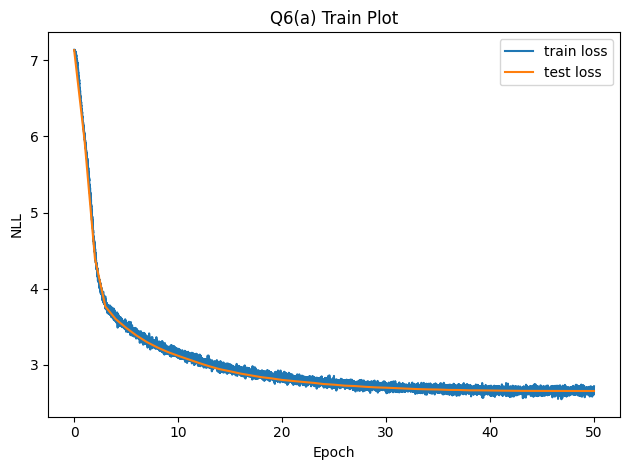

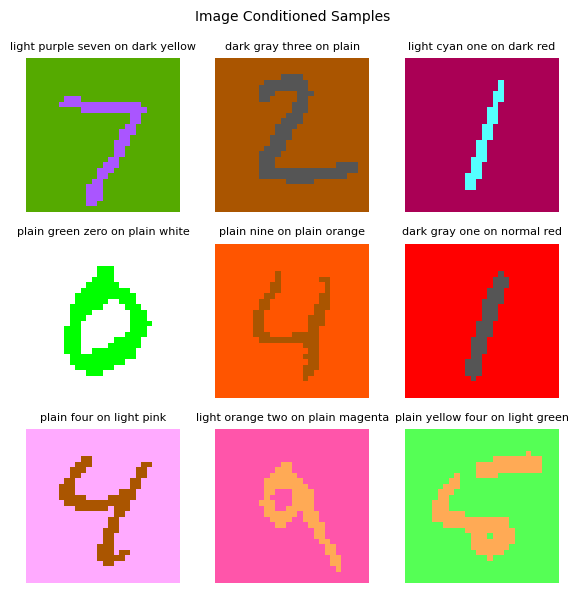

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-33..299].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-13..178].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18..289].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-19..294].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-11..260].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-14..263].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-24..311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for 

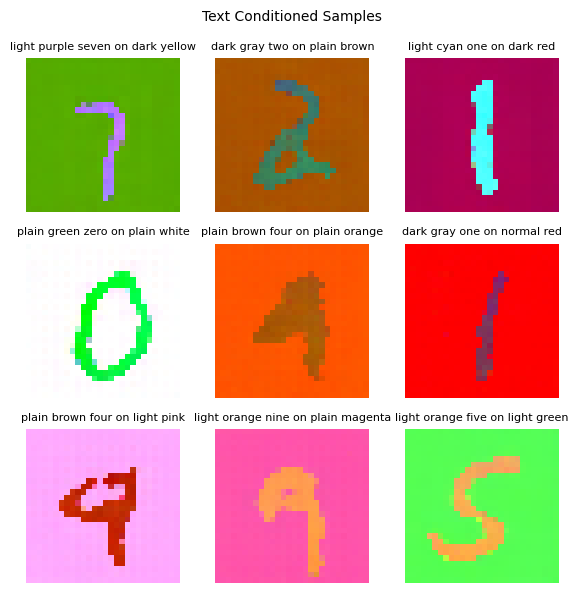

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [75..259].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9..285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-29..181].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2..264].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10..219].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [20..273].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [63..293].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

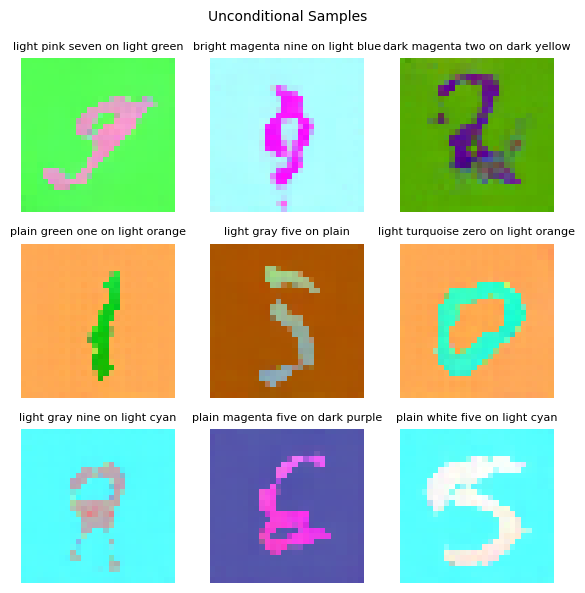

In [30]:
q6a_save_results(q6_a)